# Comparing Treatment Plans Across Time Points

This notebook demonstrates how to:
1. Load radiotherapy data from two different time points
2. Compare dose distributions between plans
3. Compare structure contours and detect geometric changes
4. Compute dosimetric differences (DVH, mean dose, max dose)
5. Visualize dose differences spatially

This is particularly useful for:
- Comparing initial vs adapted treatment plans
- Evaluating predicted vs delivered doses
- Longitudinal treatment analysis

## 1. Setup and Data Loading

First, download example data from HuggingFace which includes multiple time points.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from huggingface_hub import snapshot_download
from dosemetrics.io import load_structure_set, load_volume
from dosemetrics.dose import Dose
from dosemetrics.metrics import dvh, geometric

# Download test data (cached locally after first download)
data_path = Path(snapshot_download(
    repo_id="contouraid/dosemetrics-data",
    repo_type="dataset"
))
print(f"✓ Data downloaded to: {data_path}")


/Users/amithkamath/Repositories/ContourAId/dosemetrics/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 165 files: 100%|██████████| 165/165 [00:00<00:00, 514160.59it/s]

✓ Data downloaded to: /Users/amithkamath/.cache/huggingface/hub/datasets--contouraid--dosemetrics-data/snapshots/839ceab7ba71766265fd6a637fe799341bb0364f


## 2. Load Data from Two Time Points

Load treatment plan data from two different time points (e.g., initial planning vs adaptive replanning).

In [2]:
time_point_1_path = data_path / "longitudinal" / "time_point_1"
time_point_2_path = data_path / "longitudinal" / "time_point_2"

# Load dose distributions
dose1, spacing1, origin1 = load_volume(time_point_1_path / "Dose.nii.gz")
dose2, spacing2, origin2 = load_volume(time_point_2_path / "Dose.nii.gz")

print("Time Point 1:")
print(f"  Dose shape: {dose1.shape}")
print(f"  Dose range: [{dose1.min():.2f}, {dose1.max():.2f}] Gy")
print(f"  Mean dose: {dose1.mean():.2f} Gy")

print("\nTime Point 2:")
print(f"  Dose shape: {dose2.shape}")
print(f"  Dose range: [{dose2.min():.2f}, {dose2.max():.2f}] Gy")
print(f"  Mean dose: {dose2.mean():.2f} Gy")

# Load structure sets
structures1 = load_structure_set(time_point_1_path)
structures2 = load_structure_set(time_point_2_path)

print(f"\nStructures at Time Point 1: {len(structures1)}")
print(f"Structures at Time Point 2: {len(structures2)}")

Time Point 1:
  Dose shape: (128, 128, 128)
  Dose range: [-7.34, 65.71] Gy
  Mean dose: 4.75 Gy

Time Point 2:
  Dose shape: (128, 128, 128)
  Dose range: [-8.50, 65.42] Gy
  Mean dose: 4.27 Gy

Structures at Time Point 1: 15
Structures at Time Point 2: 15


## 3. Compare Global Dose Statistics

First, let's look at overall dose distribution differences.

Global Dose Comparison:
  Absolute mean difference: 1.220 Gy
  RMS difference: 4.928 Gy
  Max difference: 58.676 Gy
  Correlation: 0.9323


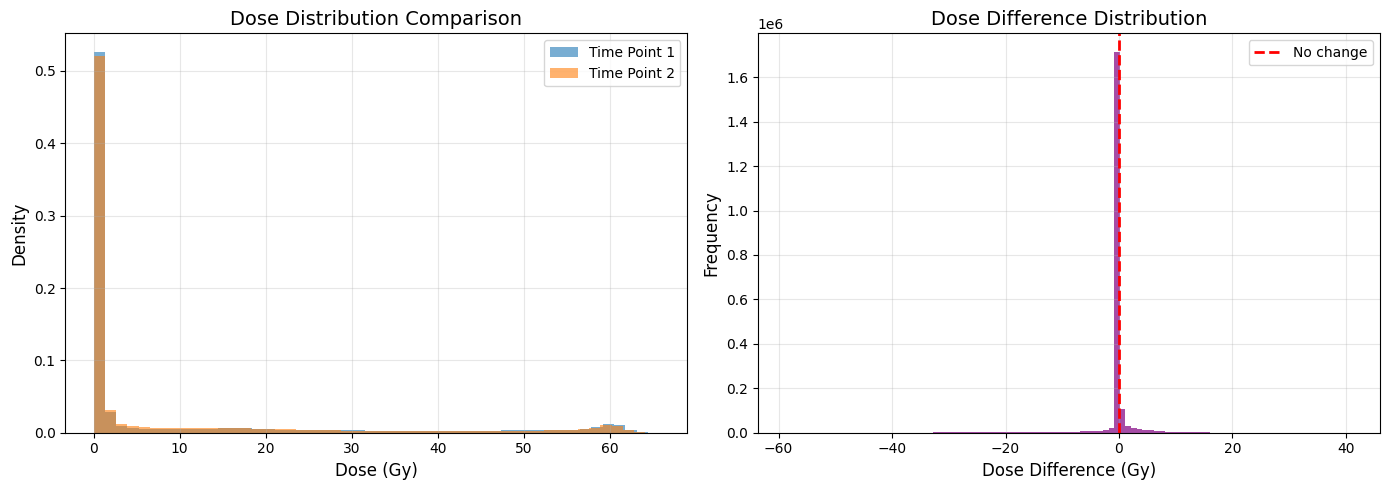

In [3]:
# Compute dose difference
dose_diff = dose2 - dose1

# Global statistics
print("Global Dose Comparison:")
print(f"  Absolute mean difference: {np.abs(dose_diff).mean():.3f} Gy")
print(f"  RMS difference: {np.sqrt(np.mean(dose_diff**2)):.3f} Gy")
print(f"  Max difference: {np.abs(dose_diff).max():.3f} Gy")
print(f"  Correlation: {np.corrcoef(dose1.flatten(), dose2.flatten())[0,1]:.4f}")

# Create histogram comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Dose histograms
axes[0].hist(dose1[dose1 > 0].flatten(), bins=50, alpha=0.6, label='Time Point 1', density=True)
axes[0].hist(dose2[dose2 > 0].flatten(), bins=50, alpha=0.6, label='Time Point 2', density=True)
axes[0].set_xlabel('Dose (Gy)', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Dose Distribution Comparison', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Difference histogram
axes[1].hist(dose_diff.flatten(), bins=100, alpha=0.7, color='purple')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='No change')
axes[1].set_xlabel('Dose Difference (Gy)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Dose Difference Distribution', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Compare Structure-Specific Doses

Analyze dose differences within specific structures (PTV and OARs).


Dose Comparison by Structure:
   Structure  Mean_T1 (Gy)  Mean_T2 (Gy)  Mean_Diff (Gy)  Max_T1 (Gy)  Max_T2 (Gy)  Max_Diff (Gy)
         PTV     60.149307     59.937557       -0.211750    65.710373    65.416031      -0.294342
   Brainstem     14.471137     15.083193        0.612056    55.573269    53.320488      -2.252781
      Chiasm     43.688713     39.935711       -3.753002    55.156136    54.743080      -0.413055
OpticNerve_L     40.706139     41.902809        1.196671    58.409367    52.708046      -5.701321
OpticNerve_R     16.820459     13.686798       -3.133661    36.039921    23.251932     -12.787989


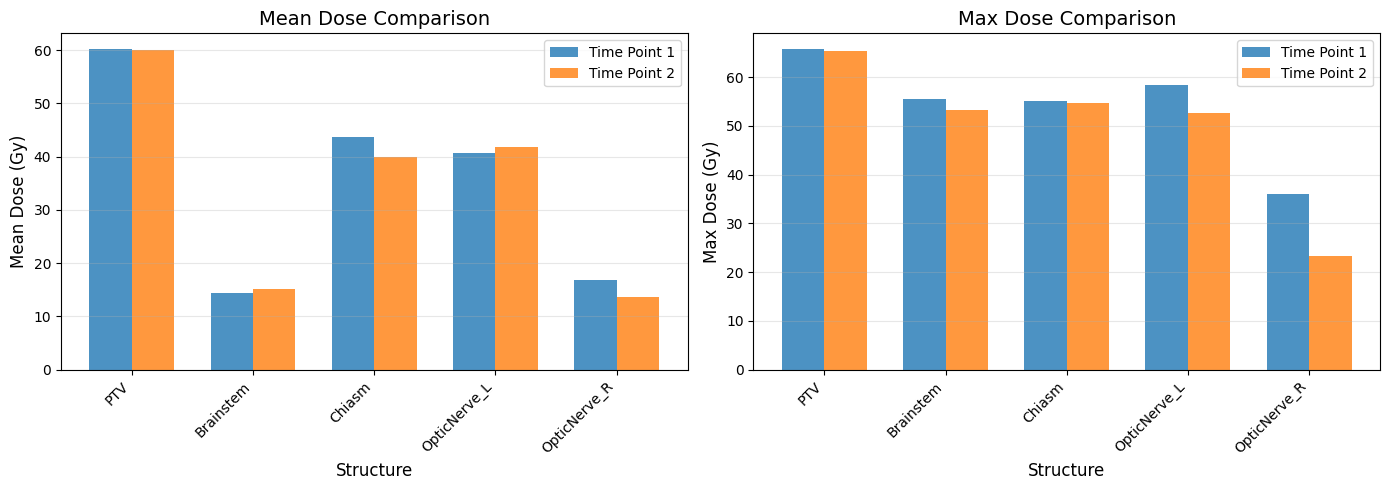

In [4]:
# Compare doses in key structures using the new API
from dosemetrics.metrics import dvh

comparison_structures = ['PTV', 'Brainstem', 'Chiasm', 'OpticNerve_L', 'OpticNerve_R']

# Create Dose objects for easier API usage
from dosemetrics import Dose
dose_obj1 = Dose(dose1, spacing1, origin1, name="Time Point 1")
dose_obj2 = Dose(dose2, spacing2, origin2, name="Time Point 2")

dose_comparison_data = []

for struct_name in comparison_structures:
    if struct_name not in structures1 or struct_name not in structures2:
        continue
    
    # Get structures
    struct1 = structures1.get_structure(struct_name)
    struct2 = structures2.get_structure(struct_name)
    
    # Compute metrics for time point 1
    stats1 = dvh.compute_dose_statistics(dose_obj1, struct1)
    
    # Compute metrics for time point 2
    stats2 = dvh.compute_dose_statistics(dose_obj2, struct2)
    
    # Compute differences
    mean_diff = stats2['mean_dose'] - stats1['mean_dose']
    max_diff = stats2['max_dose'] - stats1['max_dose']
    
    dose_comparison_data.append({
        'Structure': struct_name,
        'Mean_T1 (Gy)': stats1['mean_dose'],
        'Mean_T2 (Gy)': stats2['mean_dose'],
        'Mean_Diff (Gy)': mean_diff,
        'Max_T1 (Gy)': stats1['max_dose'],
        'Max_T2 (Gy)': stats2['max_dose'],
        'Max_Diff (Gy)': max_diff,
    })

# Create comparison DataFrame
comparison_df = pd.DataFrame(dose_comparison_data)
print("\nDose Comparison by Structure:")
print(comparison_df.to_string(index=False))

# Visualize the comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean dose comparison
x_pos = np.arange(len(comparison_df))
width = 0.35

axes[0].bar(x_pos - width/2, comparison_df['Mean_T1 (Gy)'], width, 
           label='Time Point 1', alpha=0.8)
axes[0].bar(x_pos + width/2, comparison_df['Mean_T2 (Gy)'], width, 
           label='Time Point 2', alpha=0.8)
axes[0].set_xlabel('Structure', fontsize=12)
axes[0].set_ylabel('Mean Dose (Gy)', fontsize=12)
axes[0].set_title('Mean Dose Comparison', fontsize=14)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_df['Structure'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Max dose comparison
axes[1].bar(x_pos - width/2, comparison_df['Max_T1 (Gy)'], width, 
           label='Time Point 1', alpha=0.8)
axes[1].bar(x_pos + width/2, comparison_df['Max_T2 (Gy)'], width, 
           label='Time Point 2', alpha=0.8)
axes[1].set_xlabel('Structure', fontsize=12)
axes[1].set_ylabel('Max Dose (Gy)', fontsize=12)
axes[1].set_title('Max Dose Comparison', fontsize=14)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(comparison_df['Structure'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5. Compare DVH Curves

Plot Dose-Volume Histograms (DVHs) for both time points to visualize changes.

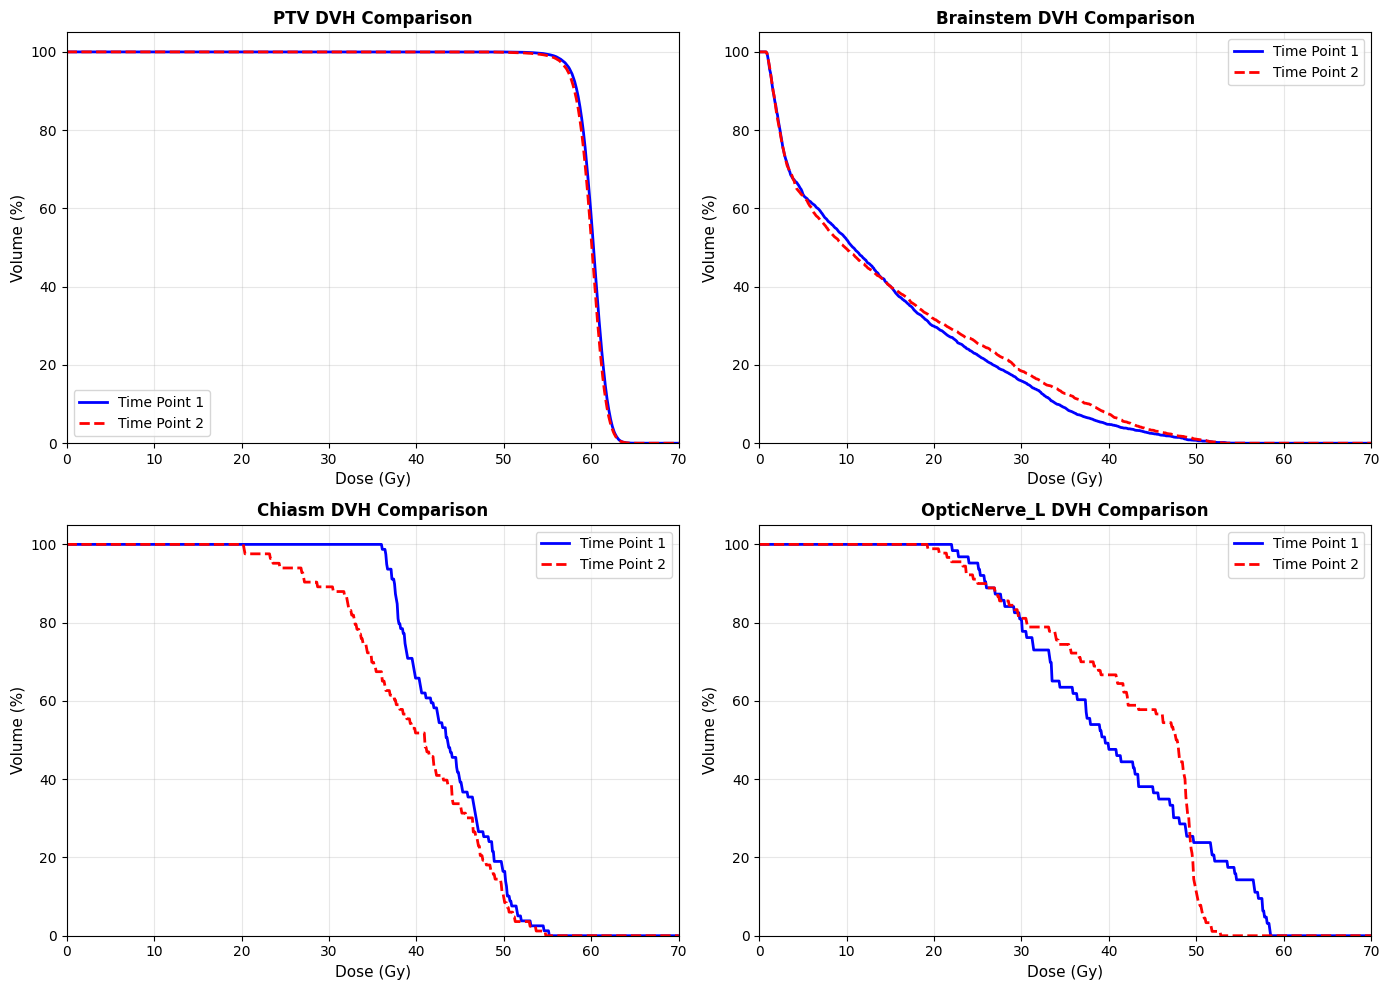

In [5]:
# Compare DVH for selected structures using the new API
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

structures_to_plot = ['PTV', 'Brainstem', 'Chiasm', 'OpticNerve_L']

for idx, struct_name in enumerate(structures_to_plot):
    if struct_name not in structures1:
        continue
    
    ax = axes[idx]
    
    # Get structures
    struct1 = structures1.get_structure(struct_name)
    struct2 = structures2.get_structure(struct_name)
    
    # Compute DVH using new API
    dvh_df1 = dvh.compute_dvh(dose_obj1, struct1, step_size=0.1, max_dose=70.0)
    dvh_df2 = dvh.compute_dvh(dose_obj2, struct2, step_size=0.1, max_dose=70.0)
    
    # Plot
    ax.plot(dvh_df1[0], dvh_df1[1], label='Time Point 1', linewidth=2, color='blue')
    ax.plot(dvh_df2[0], dvh_df2[1], label='Time Point 2', linewidth=2, color='red', linestyle='--')
    ax.set_xlabel('Dose (Gy)', fontsize=11)
    ax.set_ylabel('Volume (%)', fontsize=11)
    ax.set_title(f'{struct_name} DVH Comparison', fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 70])
    ax.set_ylim([0, 105])

plt.tight_layout()
plt.show()

## 6. Compare Structure Geometries

Analyze geometric changes in structure contours between time points.


Geometric Comparison:
   Structure  Volume_T1  Volume_T2  Volume_Change  Volume_Change_%  Dice_Coefficient
         PTV      46058      39637          -6421       -13.941118          0.823175
   Brainstem       3152       3090            -62        -1.967005          0.801346
      Chiasm         79         83              4         5.063291          0.012346
OpticNerve_L         63         90             27        42.857143          0.104575
OpticNerve_R         82         97             15        18.292683          0.134078


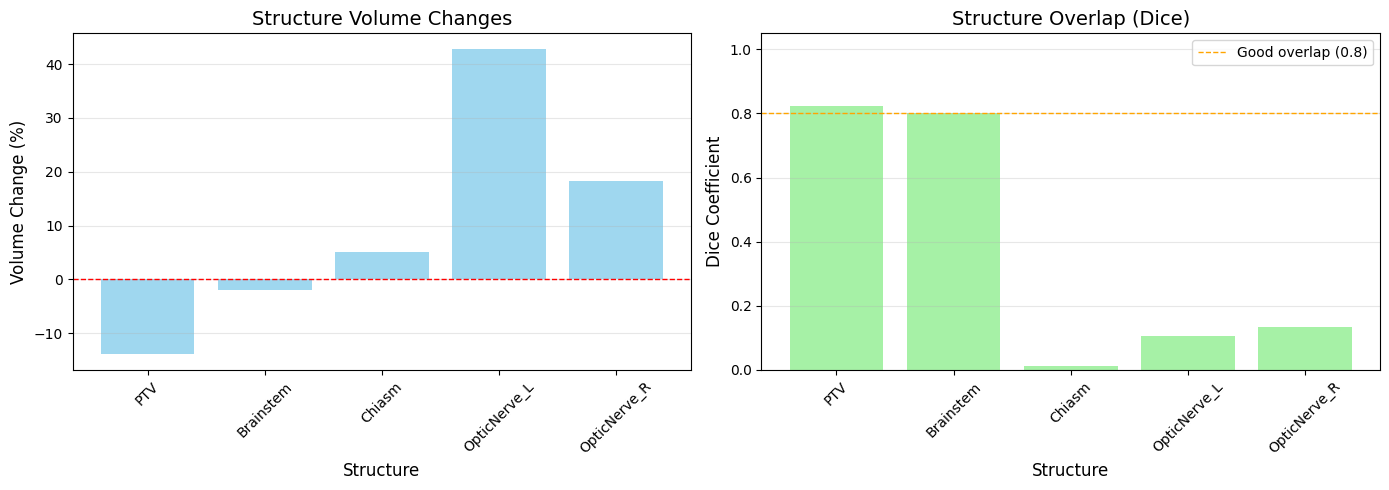

In [6]:
# Compare structure geometries using the new API
from dosemetrics.metrics import geometric

geometric_comparison = []

for struct_name in comparison_structures:
    if struct_name not in structures1 or struct_name not in structures2:
        continue
    
    struct1 = structures1.get_structure(struct_name)
    struct2 = structures2.get_structure(struct_name)
    
    # Volume in voxels
    volume1 = struct1.mask.sum()
    volume2 = struct2.mask.sum()
    volume_change = volume2 - volume1
    volume_change_pct = (volume_change / volume1 * 100) if volume1 > 0 else 0
    
    # Dice coefficient
    dice = geometric.compute_dice_coefficient(struct1, struct2)
    
    geometric_comparison.append({
        'Structure': struct_name,
        'Volume_T1': volume1,
        'Volume_T2': volume2,
        'Volume_Change': volume_change,
        'Volume_Change_%': volume_change_pct,
        'Dice_Coefficient': dice,
    })

geo_df = pd.DataFrame(geometric_comparison)
print("\nGeometric Comparison:")
print(geo_df.to_string(index=False))

# Visualize geometric metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Volume change
axes[0].bar(geo_df['Structure'], geo_df['Volume_Change_%'], color='skyblue', alpha=0.8)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0].set_xlabel('Structure', fontsize=12)
axes[0].set_ylabel('Volume Change (%)', fontsize=12)
axes[0].set_title('Structure Volume Changes', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Dice coefficient
axes[1].bar(geo_df['Structure'], geo_df['Dice_Coefficient'], color='lightgreen', alpha=0.8)
axes[1].axhline(y=0.8, color='orange', linestyle='--', linewidth=1, label='Good overlap (0.8)')
axes[1].set_xlabel('Structure', fontsize=12)
axes[1].set_ylabel('Dice Coefficient', fontsize=12)
axes[1].set_title('Structure Overlap (Dice)', fontsize=14)
axes[1].set_ylim([0, 1.05])
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 7. Visualize Spatial Dose Differences

Show dose differences slice by slice to identify regions of change.

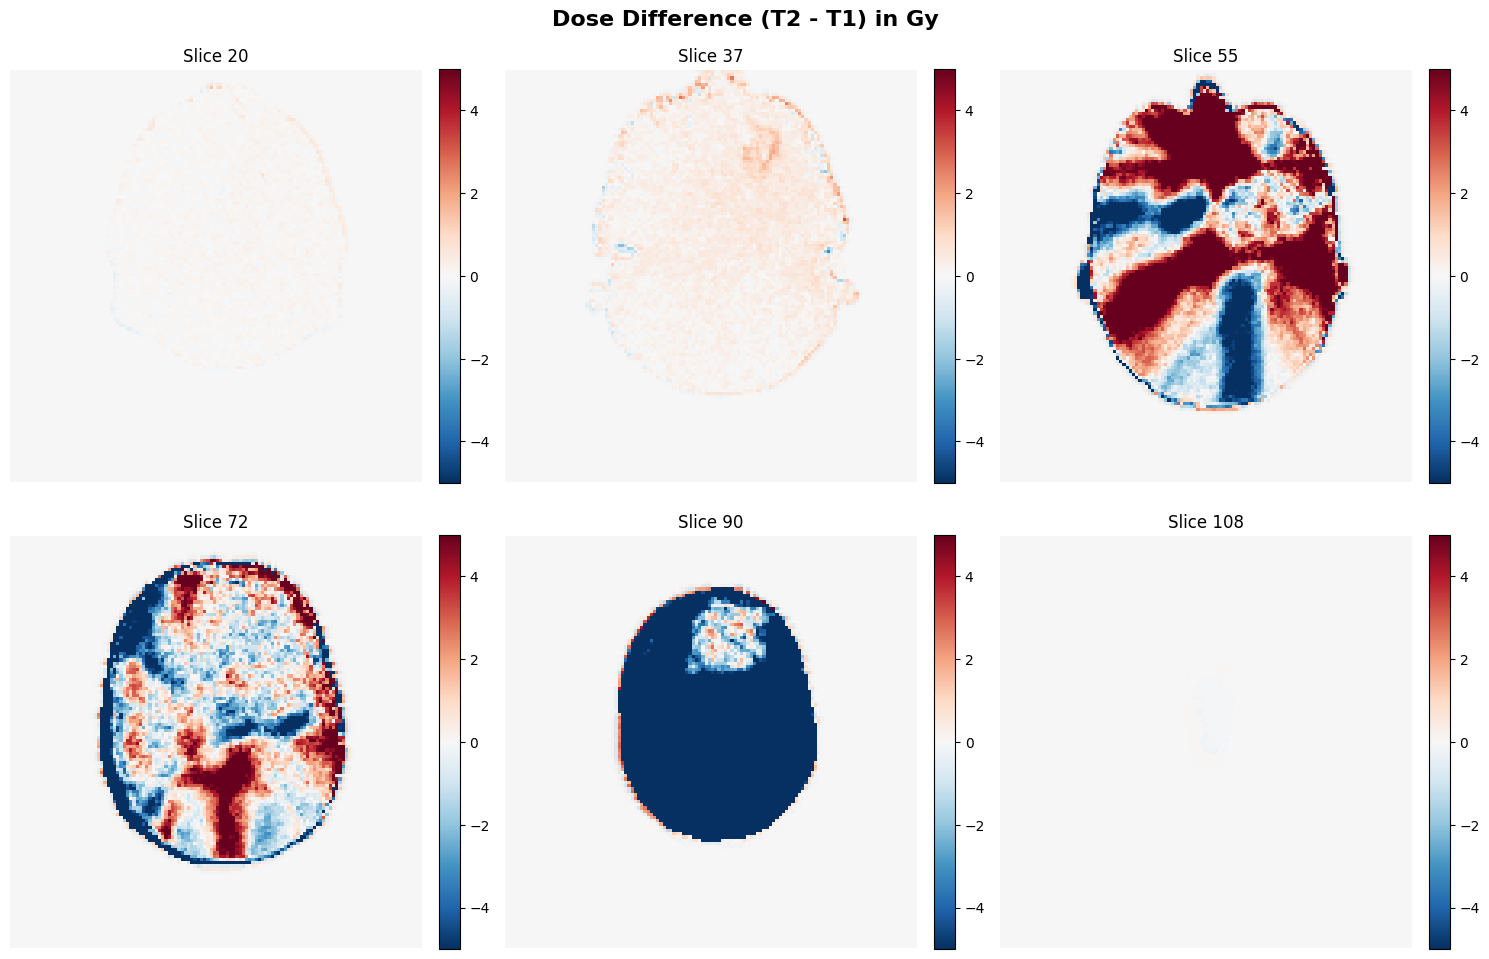

\nDose difference legend:
  Red: Higher dose at Time Point 2
  Blue: Lower dose at Time Point 2
  White: No significant change


In [7]:
# Visualize dose differences on selected slices
n_slices = 6
slice_indices = np.linspace(20, dose1.shape[0] - 20, n_slices, dtype=int)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, slice_idx in enumerate(slice_indices):
    ax = axes[idx]
    
    # Get the slice
    diff_slice = dose_diff[slice_idx, :, :]
    
    # Plot
    im = ax.imshow(diff_slice, cmap='RdBu_r', vmin=-5, vmax=5)
    ax.set_title(f'Slice {slice_idx}', fontsize=12)
    ax.axis('off')
    
    # Add colorbar
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

fig.suptitle('Dose Difference (T2 - T1) in Gy', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\\nDose difference legend:")
print("  Red: Higher dose at Time Point 2")
print("  Blue: Lower dose at Time Point 2")
print("  White: No significant change")

## 8. Export Comparison Results

Save the comparison results to CSV files for further analysis.

In [8]:
# Save comparison results to temporary directory
import tempfile

temp_dir = Path(tempfile.mkdtemp(prefix="dosemetrics_comparison_"))
print(f"✓ Using temporary directory: {temp_dir}")

# Save dose comparison
comparison_df.to_csv(temp_dir / "dose_comparison.csv", index=False)
print(f"✓ Saved dose comparison to: {temp_dir / 'dose_comparison.csv'}")

# Save geometric comparison
geo_df.to_csv(temp_dir / "geometric_comparison.csv", index=False)
print(f"✓ Saved geometric comparison to: {temp_dir / 'geometric_comparison.csv'}")

print("\n✓ All comparison results exported successfully!")
print(f"\n Results saved in temporary directory: {temp_dir}")

✓ Using temporary directory: /var/folders/yr/q_0gpqgs1lq_rtbttpk3n9bh0000gn/T/dosemetrics_comparison_muv13lm_
✓ Saved dose comparison to: /var/folders/yr/q_0gpqgs1lq_rtbttpk3n9bh0000gn/T/dosemetrics_comparison_muv13lm_/dose_comparison.csv
✓ Saved geometric comparison to: /var/folders/yr/q_0gpqgs1lq_rtbttpk3n9bh0000gn/T/dosemetrics_comparison_muv13lm_/geometric_comparison.csv

✓ All comparison results exported successfully!

 Results saved in temporary directory: /var/folders/yr/q_0gpqgs1lq_rtbttpk3n9bh0000gn/T/dosemetrics_comparison_muv13lm_


## Summary

In this notebook, you learned how to:

1. ✓ Load radiotherapy data from multiple time points
2. ✓ Compare global dose distribution statistics
3. ✓ Analyze structure-specific dose changes
4. ✓ Compare DVH curves across time points
5. ✓ Evaluate geometric changes in structure contours (volume, Dice coefficient)
6. ✓ Visualize spatial dose differences
7. ✓ Export comparison results for reporting

## Key Metrics for Plan Comparison

**Dosimetric Metrics:**
- Mean dose per structure
- Maximum dose per structure
- DVH curves and metrics
- Global dose statistics (RMS, correlation)

**Geometric Metrics:**
- Volume changes
- Dice similarity coefficient (overlap)
- Centroid distance
- Hausdorff distance

## Real-World Applications

This workflow is valuable for:
- **Adaptive Radiotherapy**: Comparing initial vs adapted plans
- **Quality Assurance**: Verifying predicted vs delivered doses
- **Clinical Research**: Analyzing treatment response and anatomical changes
- **Machine Learning**: Validating dose prediction models

## Next Steps

- **Quality Indices**: Compute conformity indices and compliance metrics
- **Advanced Metrics**: Gamma analysis, dose gradients
- **Batch Processing**: Automate comparison for multiple patients
- **Statistical Analysis**: Perform population-level comparisons

## References

- [DoseMetrics Documentation](https://contouraid.github.io/dosemetrics/)
- [GitHub Repository](https://github.com/contouraid/dosemetrics)